# Atividade 02: Máquina de Vetor de Suporte (SVM) Multiclasse

*Complete e entregue toda essa atividade (incluindo suas saídas e qualquer código adicional que você desenvolva) juntamente com a submissão de seu trabalho prático. Maiores detalhes podem ser vistos na página da disciplina.*

Nessa atividade, você irá:

- implementar uma **função de perda** (**loss function**) de forma completamente paralela para SVM
- implementar a expressão para seu **gradiente analítico** de forma completamente paralela
- **verificar sua implementação** utilizando gradiente numérico
- usar um conjunto de validação para **ajustar a taxa de aprendizado e regularização**
- **otimizar** a função de perda com **SGD**
- **visualizar** os pesos finais que foram obtidos


In [21]:
# Executa algum código de inicialização para este notebook.

import random
import numpy as np
from dl.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# Um pouco de 'mágica': Isto permite que as figuras geradas pela biblioteca matplotlib apareçam dentro do notebook
# ao invés de aparecer em uma nova janela.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Um pouco mais de 'mágica', assim o notebook irá recarregar módulos python externos;
# veja mais em http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print('Okay!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Okay!


## CIFAR-10 Dataset: Carga e Preprocessamento dos Dados

In [22]:
# Carrega os dados brutos da base CIFAR-10.
cifar10_dir = 'dl/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Apenas para verificação, vamos exibir o tamanho dos dados de treinamento e teste.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

print('Okay!')

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)
Okay!


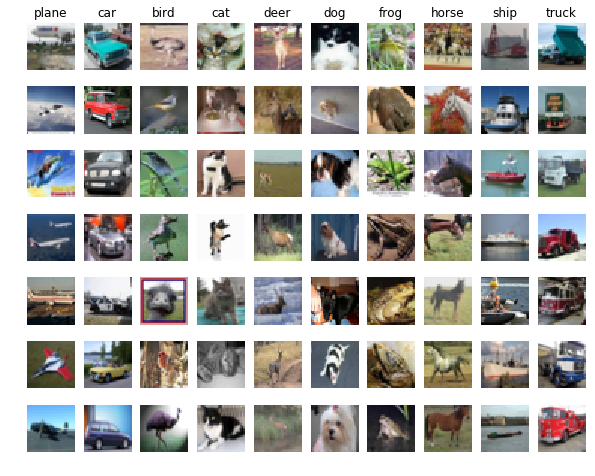

Okay!


In [23]:
# Visualizar alguns exemplos do dataset.
# São exibidos apenas 7 exemplos de imagens de treinamento de cada classe.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

print('Okay!')

In [24]:
# Particiona os dados em conjuntos de treinamento, validação e teste.
# Além disso, cria-se um pequeno conjunto de dados de treinamento para
# ser usado durante o desenvolvimento. 
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# O conjunto de validação irá conter num_validation pontos do conjunto 
# original de treinamento.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# O conjunto de treinamento será formado pelos primeiros num_train pontos
# do conjunto original de treinamento.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Cria-se um conjunto para desenvolvimento, que será uma pequeno subconjunto
# do conjunto de treinamento.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# O conjunto de teste irá conter os primeiros num_test pontos do
# conjunto de testes (que corresponde a todo ele).
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

print('Okay!')

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)
Okay!


In [25]:
# Preprocessamento: reformata os dados das imagens, assim as matrizes são transformadas em vetores
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Apenas para verificação, vamos exibir o tamanho dos dados de treinamento, validação, teste e desenvolvimento.
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

print('Okay!')

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)
Okay!


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


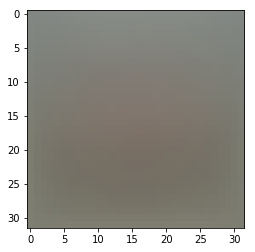

Okay!


In [26]:
# Preprocessamento: subtrair a imagem média
# Primeiro: calcular a imagem média com base nos dados de treinamento
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # exibe alguns elementos
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualiza a imagem média
plt.show()

print('Okay!')

In [27]:
# Segundo: subtrai propriamente a imagem média dos dados de treinamento, validação, teste e desenvolvimento
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

print('Okay!')

Okay!


In [28]:
# Terceiro: acrescenta-se uma dimensão de 'uns' (conhecido como 'bias trick') assim nosso modelo SVM
# somente precisa se preocupar em otimizar uma única matriz de pesos W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

print('Okay!')

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)
Okay!


## Classificador SVM

Seu código para esta seção será todo escrito dentro do arquivo `dl/classifiers/linear_svm.py`.

Como você pode observar (abrindo o arquivo em questão), a função `compute_loss_naive` já possui código para avaliar a função de perda do SVM multiclasse utilizando laços.

In [29]:
# Avalia a implementação ingênua de cálculo da função de perda já fornecida:
from dl.classifiers.linear_svm import svm_loss_naive
import time

# Produz uma matrix com números aleatórios e pequenos que serão usados como pesos do SVM 
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

print('Okay!')

loss: 8.966657
Okay!


O **grad** retornado pela função acima ainda está todo zerado. Você deve derivar e implementar o gradiente para a função de custo (ou perda) do SVM e esse implementação deve ser colocada dentro da função `svm_loss_naive`. Provavelmente, você irá achar mais fácil combinar (e intercalar) seu código com o já existente na função (aproveitando os *loops* e  testes já existentes).

De forma a verificar se você implementou o gradiente analítico corretamente, pode-se estimar numericamento o gradiente da função de perda e comparar essa estimativa numérica com o valor calculado pela sua implementação. 

A seguir, você vai encontrar o código para realizar essa verificação.

In [30]:
# uma vez que você tenha implementado o gradiente, recalcule seu valor com
# o código abaixo e verifique utilizando a função fornecida

# Calcula a perda e seu gadiente em W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Calcula numericamente o gadiente em diversas direções escolhidas randomicamente
# e compara os valores obtidos com o calculado analiticamente. Os números devem 
# ser praticamente coincidentes em todas as direções.
from dl.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# Você deve fazer a verificação novamente utilizando regularização
# CUIDADO: é comum se esquecer da regularização no cálculo do gadiente
# Você esqueceu? nop
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)
print('Okay!')

numerical: -1.905510 analytic: -1.905510, relative error: 2.311456e-10
numerical: 9.751809 analytic: 9.751809, relative error: 3.690111e-11
numerical: 5.215338 analytic: 5.215338, relative error: 2.400540e-11
numerical: 24.199166 analytic: 24.199166, relative error: 5.807859e-12
numerical: -9.257600 analytic: -9.257600, relative error: 3.096565e-11
numerical: -43.588184 analytic: -43.579134, relative error: 1.038220e-04
numerical: -17.707643 analytic: -17.707643, relative error: 6.919986e-12
numerical: 10.813057 analytic: 10.813057, relative error: 1.342372e-11
numerical: 12.375528 analytic: 12.375528, relative error: 6.311618e-11
numerical: -3.971721 analytic: -3.971721, relative error: 3.888083e-11
numerical: -5.257579 analytic: -5.257579, relative error: 3.764004e-11
numerical: 2.913284 analytic: 2.913284, relative error: 3.850829e-11
numerical: 12.769398 analytic: 12.769398, relative error: 4.462956e-11
numerical: 31.975893 analytic: 31.975893, relative error: 6.824409e-12
numerica

### Pergunta 01:
É possível que eventualmente em uma dimensão a verificação de gadiente não seja coincidente. O que pode causar essa discrepância? Isso representa um motivo de preocupação? Qual seria um simples exemplo em um dimensão em que a verificação de gradiente acima poderia falhar? *Dica: a função de perda do SVM não é estritamente diferenciável.*

**Sua Resposta:** *Essa discrepância pode acontecer pelo fato da função de perda SVM não ser diferenciável na dimensão em que está sendo calculada.*

In [31]:
# A seguir, você deve implementar a versão vetorial (paralelizada) do cálculo da 
# função de perda preenchendo o corpo da função svm_loss_vectorized
# Por ora, calcule apenas a perda, logo adiante o gradiente será solicitado
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from dl.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# Os valores de perda devem coincidir porém a versão vetorial deve ser mais rápida.
print('difference: %f' % (loss_naive - loss_vectorized))

print('Okay!')

Naive loss: 8.966657e+00 computed in 0.317813s
Vectorized loss: 8.966657e+00 computed in 0.025376s
difference: -0.000000
Okay!


In [32]:
# Agora, complete a implementação da função svm_loss_vectorizes, e calcule o
# gradiente da função de perda de forma paralela/vetorizada.

# Novamente, os valores devem coincidir porém a versão vetorial deve ser mais rápida.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# A perda é um escalar, portanto é fácil comparar os valores calculados
# pelas duas implementações. Os gradientes por outro lado são matrizes, então
# utiliza-se a norma de Frobenius para compará-los.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

print('Okay!')

Naive loss and gradient: computed in 0.251888s
Vectorized loss and gradient: computed in 0.004879s
difference: 0.000000
Okay!


### Stochastic Gradient Descent (Método de Descida Mais Íngreme Estocástico)

Agora, você dispõe de versões eficientes para cálculo da perda e do gradiente (além disso, o gradiente analítico calculado coincide com o estimado mnumericamente). Desse modo, você está pronto para usar SGD e otimizar a perda.

In [34]:
# No arquivo linear_classifier.py, você deve implementar SGD na função 
# LinearClassifier.train() e executar o seguinte código para testar.
from dl.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

print('Okay!')

iteration 0 / 1500: loss 402.123804
iteration 100 / 1500: loss 239.194343
iteration 200 / 1500: loss 146.930610
iteration 300 / 1500: loss 90.514647
iteration 400 / 1500: loss 56.899269
iteration 500 / 1500: loss 36.166086
iteration 600 / 1500: loss 23.968124
iteration 700 / 1500: loss 15.423417
iteration 800 / 1500: loss 11.354522
iteration 900 / 1500: loss 8.706789
iteration 1000 / 1500: loss 7.352121
iteration 1100 / 1500: loss 6.453183
iteration 1200 / 1500: loss 5.748049
iteration 1300 / 1500: loss 5.437952
iteration 1400 / 1500: loss 4.702156
That took 10.779705s
Okay!


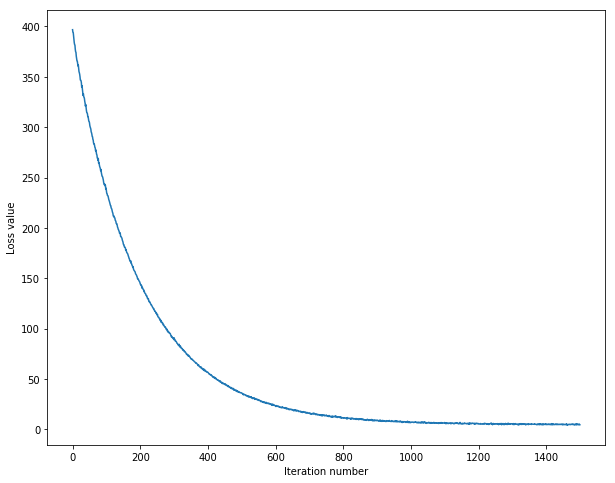

Okay!


In [39]:
# Uma estratégia de depuração muito útil é plotar a perda em função 
# do número de iterações
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

print('Okay!')

In [40]:
# Implemente agora a função LinearSVM.predict e avalie o resultado de predição
# tanto no conjunto de treinamento quanto no conjunto de validação
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

print('Okay!')

training accuracy: 0.359061
validation accuracy: 0.377000
Okay!


In [62]:
# Utilize o conjunto de validação para ajustar os hiperparâmetros (taxa de 
# aprendizado e regularização). Você deve experimentar diferentes intervalos
# para ambos. Se você proceder corretamente deve ser capaz de obter uma acurácia
# em torno de 0.4 no conjunto de validação.

learning_rates = [1e-8, 1e-7, 2e-7]
regularization_strengths = [1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 1e5]

# results é um dicionário que mapeia tuplas da seguinte forma
# (learning_rate, regularization_strength) em tuplas cuja forma é 
# (training_accuracy, validation_accuracy). A acurácia é obtida simplesmente como
# a fração dos pontos corretamente classificados (ou taxa de acerto).
results = {}
best_val = -1   # O valor da maior acurácia de validação obtida até o momento.
best_svm = None # O objeto LinearSVM que alcançou o melhor resultado.

################################################################################
# TODO:                                                                        #
# Escrever o código que escolhe os melhores hiperparâmetros usando o conjunto  #
# de validação. Para cada combinação de hiperparâmetros, treina-se um SVM      #
# linear sobre o conjunto de treinamento, calcula-se sua acurácia sobre os     #
# conjuntos de de treinamento e validação e armazena-se esses valores no       #
# dicionario results. Além disso, armazena-se a melhor acurácia de validação   #
# em best_val e o objeto LinearSVM que obteve esse resultado em best_svm.      #
#                                                                              #
# Dica: Você deve usar um valor pequeno para num_iters na medida que você      #
# verifica seu código, assim o SVM não leva muito tempo treinamento. Quando    #
# você estiver confiante de que seu código funciona corretamente, então você   #
# pode re-executar utilizando o valor maior para num_iters.
################################################################################
for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(
            X_train, y_train, learning_rate, \
            regularization_strength, num_iters=1500, batch_size=200)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        training_accuracy = np.mean(y_train == y_train_pred)
        validation_accuracy = np.mean(y_val == y_val_pred)
        results[(learning_rate, regularization_strength)] = \
        (training_accuracy, validation_accuracy)
        
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_svm = svm
################################################################################
#                              FIM DE SEU CÓDIGO                               #
################################################################################
    
# Exibe os resultados.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print ('lr %e reg %e train accuracy: %f val accuracy: %f' % (lr, reg, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 1.000000e+04 train accuracy: 0.217347 val accuracy: 0.234000
lr 1.000000e-08 reg 2.000000e+04 train accuracy: 0.231490 val accuracy: 0.227000
lr 1.000000e-08 reg 3.000000e+04 train accuracy: 0.232939 val accuracy: 0.247000
lr 1.000000e-08 reg 4.000000e+04 train accuracy: 0.245510 val accuracy: 0.257000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.249796 val accuracy: 0.236000
lr 1.000000e-08 reg 6.000000e+04 train accuracy: 0.265776 val accuracy: 0.267000
lr 1.000000e-08 reg 7.000000e+04 train accuracy: 0.274408 val accuracy: 0.274000
lr 1.000000e-08 reg 8.000000e+04 train accuracy: 0.281796 val accuracy: 0.290000
lr 1.000000e-08 reg 1.000000e+05 train accuracy: 0.301367 val accuracy: 0.320000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.373592 val accuracy: 0.371000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.383286 val accuracy: 0.385000
lr 1.000000e-07 reg 3.000000e+04 train accuracy: 0.378878 val accuracy: 0.386000
lr 1.000000e-07 reg 4.000000

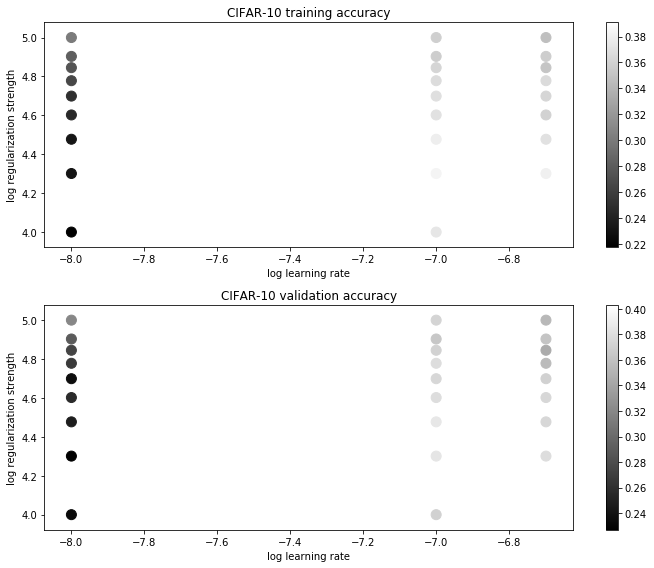

Okay!


In [63]:
# Visualiza os resultados da validação cruzada
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# Plota acurácia do treinamento
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# Plota acurácia da valisação
colors = [results[x][1] for x in results] # tamanho default de marcadores é 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.tight_layout()
plt.show()

print('Okay!')

In [64]:
# Avalia o melhor modelo SVM no conjunto de teste
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

print('Okay!')

linear SVM on raw pixels final test set accuracy: 0.368000
Okay!


Okay!


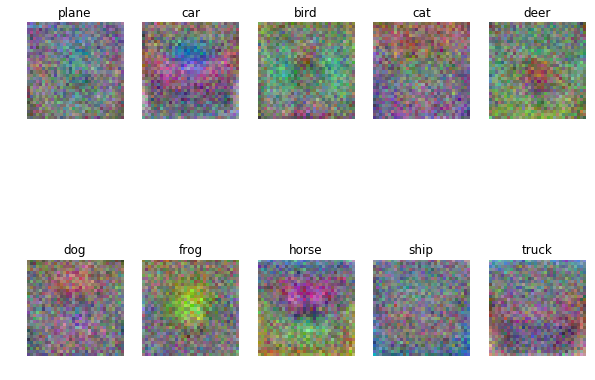

In [65]:
# Visualiza os pesos obtidos para cada classe.
# Dependendo de sua escolha de taxa de aprendizado e regularização, essas imagens
# podem ou não ser interessante de examinar.
w = best_svm.W[:-1,:] # remove o viés/bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Redimensiona os pesos para o intervalo entre 0 e 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])
    
print('Okay!')

### Pergunta 02:
Descreva como as imagens de visualização dos pesos do SVM se parecem, e forneça uma explicação breve sobre a razão para elas se apresentarem de tal forma.

**Sua Resposta:** *As imagens dos pesos parecem a imagem em baixa resolução, com um contraste grande dentre o objeto detectado e o fundo.*